In [66]:
import numpy as np
from scipy import stats
import pandas as pd
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import f
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.utils import resample
import statsmodels.stats.multitest as smt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as Naive_Bayes
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
#from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier

In [67]:
data = pd.read_excel('PD_data.xlsx')
data.head(5)

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1


In [68]:
data.dtypes

name                 object
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
status                int64
dtype: object

In [69]:
num_cols = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)','MDVP:Jitter(%)', 
            'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 
            'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 
            'NHR', 'HNR', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE', 'status']

In [70]:
corr_matrix = data[num_cols].corr()

# compute the p-values for the correlation coefficients
p_values = data[num_cols].corr(method=lambda x, y: stats.pearsonr(x, y)[1].round(3)) - np.eye(len(num_cols))

In [71]:
# variation_freq = ['MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP']
# variation_amp = ['MDVP:Shimmer', 'MDVP:Shimmer(dB)','Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA']
# fund_freq_vars = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'status']

In [72]:
def count_outliers_iqr(column):
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    upper_threshold = q3 + 1.5 * iqr
    lower_threshold = q1 - 1.5 * iqr
    num_outliers = sum((column > upper_threshold) | (column < lower_threshold))
    return num_outliers

for col in num_cols:
    num_outliers = count_outliers_iqr(data[col])
    print(f"Number of outliers in {col}: {num_outliers}")

Number of outliers in MDVP:Fo(Hz): 0
Number of outliers in MDVP:Fhi(Hz): 11
Number of outliers in MDVP:Flo(Hz): 9
Number of outliers in MDVP:Jitter(%): 14
Number of outliers in MDVP:Jitter(Abs): 7
Number of outliers in MDVP:RAP: 14
Number of outliers in MDVP:PPQ: 15
Number of outliers in Jitter:DDP: 14
Number of outliers in MDVP:Shimmer: 8
Number of outliers in MDVP:Shimmer(dB): 10
Number of outliers in Shimmer:APQ3: 6
Number of outliers in Shimmer:APQ5: 13
Number of outliers in MDVP:APQ: 12
Number of outliers in Shimmer:DDA: 6
Number of outliers in NHR: 19
Number of outliers in HNR: 3
Number of outliers in RPDE: 0
Number of outliers in DFA: 0
Number of outliers in spread1: 4
Number of outliers in spread2: 2
Number of outliers in D2: 1
Number of outliers in PPE: 5
Number of outliers in status: 48


In [73]:
data['MDVP:F_Spd'] = data['MDVP:Fhi(Hz)'] - data['MDVP:Flo(Hz)']

In [74]:
df = data
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE', 'status', 'MDVP:F_Spd'],
      dtype='object')

In [75]:
df = df.drop(['name','status'], axis = 1)

In [76]:
df.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE', 'MDVP:F_Spd'],
      dtype='object')

In [77]:
# Standardize the data in the new dataframe
scaler = StandardScaler()
df_scale = scaler.fit_transform(df)

df_scaled = pd.DataFrame(df_scale, columns=['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 
                                            'MDVP:Jitter(%)','MDVP:Jitter(Abs)', 'MDVP:RAP', 
                                            'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 
                                            'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
                                            'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 
                                            'spread1', 'spread2', 'D2', 'PPE', 'MDVP:F_Spd'])

In [78]:
df_scaled = df_scaled.drop(['MDVP:Jitter(%)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 
                          'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 
                          'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)'], axis = 1)

In [79]:
df_scaled.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer', 'NHR', 'HNR', 'RPDE',
       'DFA', 'spread1', 'spread2', 'D2', 'PPE', 'MDVP:F_Spd'],
      dtype='object')

In [80]:
df_scaled['status'] = data['status'].copy()

In [81]:
corr_matrix = df_scaled.corr()

# compute the p-values for the correlation coefficients
p_values = df_scaled.corr(method=lambda x, y: stats.pearsonr(x, y)[1].round(3)) - np.eye(len(df_scaled.columns))

In [82]:
# ftest_scaled_results = pd.DataFrame(columns=['Independent Variable', 'F-Statistic', 'p-value'])
# scale_cols = ['MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'MDVP:Shimmer', 'NHR', 'HNR', 'RPDE','DFA', 
#               'spread1', 'spread2', 'D2', 'PPE', 'MDVP:F_Spd']

# # Iterate over the columns in the DataFrame and apply the f_test function to each one
# for col in scale_cols:
#     f_stat, p_value = f_test(df_scaled, col, 'status')
#     ftest_scaled_results = ftest_scaled_results.append({'Independent Variable': col, 'F-Statistic': f_stat, 'p-value': p_value}, ignore_index=True)

# # Print the results table
# print(ftest_scaled_results)


# Applying Dimensionality Reduction Techniques such as PCA

In [83]:
df_pc = data
df_pc.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE', 'status', 'MDVP:F_Spd'],
      dtype='object')

In [84]:
df_pc = df_pc.drop(['name'], axis = 1)

In [85]:
freq_var = ['MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP']
df_pc1 = df_pc[freq_var]  

In [86]:
df_pc1 = scaler.fit_transform(df_pc1)
df_pc1

array([[ 3.34913859e-01,  7.49759461e-01,  1.32962547e-01,
         7.60800232e-01,  1.31755322e-01],
       [ 7.15418253e-01,  1.03767418e+00,  4.53891693e-01,
         1.27680862e+00,  4.52683706e-01],
       [ 8.84990863e-01,  1.32558890e+00,  7.20769613e-01,
         1.58568688e+00,  7.21813123e-01],
       [ 7.75389054e-01,  1.32558890e+00,  5.78885149e-01,
         1.28407634e+00,  5.77676867e-01],
       [ 1.36889319e+00,  1.90141834e+00,  1.09574998e+00,
         2.04718734e+00,  1.09679260e+00],
       [ 7.15418253e-01,  1.03767418e+00,  4.47135289e-01,
         1.47303716e+00,  4.45927319e-01],
       [-5.97735498e-01, -4.01899420e-01, -5.93350781e-01,
        -5.18319151e-01, -5.92304156e-01],
       [-6.86657720e-01, -4.01899420e-01, -6.30510998e-01,
        -5.90996388e-01, -6.31716413e-01],
       [-1.46920509e-01,  4.61844741e-01, -1.27158970e-01,
        -4.59171060e-02, -1.26113450e-01],
       [-1.86211724e-01,  4.61844741e-01, -2.11614009e-01,
        -4.59171060e-02

In [87]:
#Applying Principal Component Analysis
pca = PCA()
pca.fit(df_pc1)
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

[9.64162746e-01 2.33046731e-02 1.11199310e-02 1.41256948e-03
 7.99702317e-08]


In [88]:
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_explained_variance_ratio >= 0.95) + 1
print(num_components)

1


In [89]:
eigenvalues = pca.explained_variance_
print(eigenvalues)

[4.84566329e+00 1.17124001e-01 5.58862511e-02 7.09925385e-03
 4.01912247e-07]


In [90]:
pca = PCA(n_components=num_components)
pca_data = pca.fit_transform(df_pc1)

In [91]:
pca_data = pd.DataFrame(pca_data, columns = ['Jitter_pc'])
df_pc1 = pd.DataFrame(df_pc1, columns = ['MDVP:Jitter(%)','MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP'])
pca_data

,Jitter_pc
0,0.934818
1,1.751692
2,2.333009
3,2.020036
4,3.346368
...,...
190,-0.671672
191,-0.312219
192,2.393083
193,0.254103


In [92]:
df_pc['Jitter_pc'] = pca_data['Jitter_pc']

In [93]:
df_pc.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE', 'status', 'MDVP:F_Spd', 'Jitter_pc'],
      dtype='object')

In [94]:
variation_amp = ['MDVP:Shimmer', 'MDVP:Shimmer(dB)','Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA']

pca2 = PCA()
df_pc2 = df_pc[variation_amp]
df_pc2 = scaler.fit_transform(df_pc2)

pca2.fit(df_pc2)
explained_variance_ratio = pca2.explained_variance_ratio_
print(explained_variance_ratio)

[9.67891293e-01 2.39668230e-02 4.97378202e-03 2.88262892e-03
 2.85467090e-04 6.01341259e-09]


In [95]:
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_explained_variance_ratio >= 0.95) + 1
print(num_components)

1


In [96]:
eigenvalues = pca2.explained_variance_
print(eigenvalues)

[5.83728254e+00 1.44542180e-01 2.99965204e-02 1.73849270e-02
 1.72163142e-03 3.62664574e-08]


In [97]:
pca2 = PCA(n_components=num_components)
data_transformed2 = pca2.fit_transform(df_pc2)

In [98]:
data_transformed2 = pd.DataFrame(data_transformed2, columns = ['Shimmer_pc'])
df_pc2 = pd.DataFrame(df_pc2, columns = ['MDVP:Shimmer', 'MDVP:Shimmer(dB)','Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA'])

In [99]:
df_pc['Shimmer_pc'] = data_transformed2['Shimmer_pc']

In [100]:
df_pc = df_pc.drop(['MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
                    'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
                    'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
                    'MDVP:APQ', 'Shimmer:DDA'], axis = 1)

In [101]:
df_pc.head(7)

,MDVP:Fo(Hz),NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status,MDVP:F_Spd,Jitter_pc,Shimmer_pc
0,119.992,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1,82.305,0.934818,1.700278
1,122.400,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1,34.831,1.751692,4.081638
2,116.682,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1,19.556,2.333009,2.865896
3,116.676,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1,26.505,2.020036,3.224675
4,116.014,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1,31.126,3.346368,4.471558
5,120.552,0.01222,21.378,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775,1,17.375,1.832739,2.152991
6,120.267,0.00607,24.886,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756,1,22.424,-1.211720,-1.775359


In [102]:
X = df_pc.drop(['status'], axis=1)
y = df_pc['status']

In [103]:
X_train , X_test , y_train , y_test = train_test_split(X, y , test_size=0.3, random_state=20)

### Decision Tree

In [104]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
predDT = clf.predict(X_test)

print(predDT)
accuracy = accuracy_score(y_test,predDT)*100
print("\nAccuracy of Model:",accuracy)

[0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0
 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0]

Accuracy of Model: 89.83050847457628


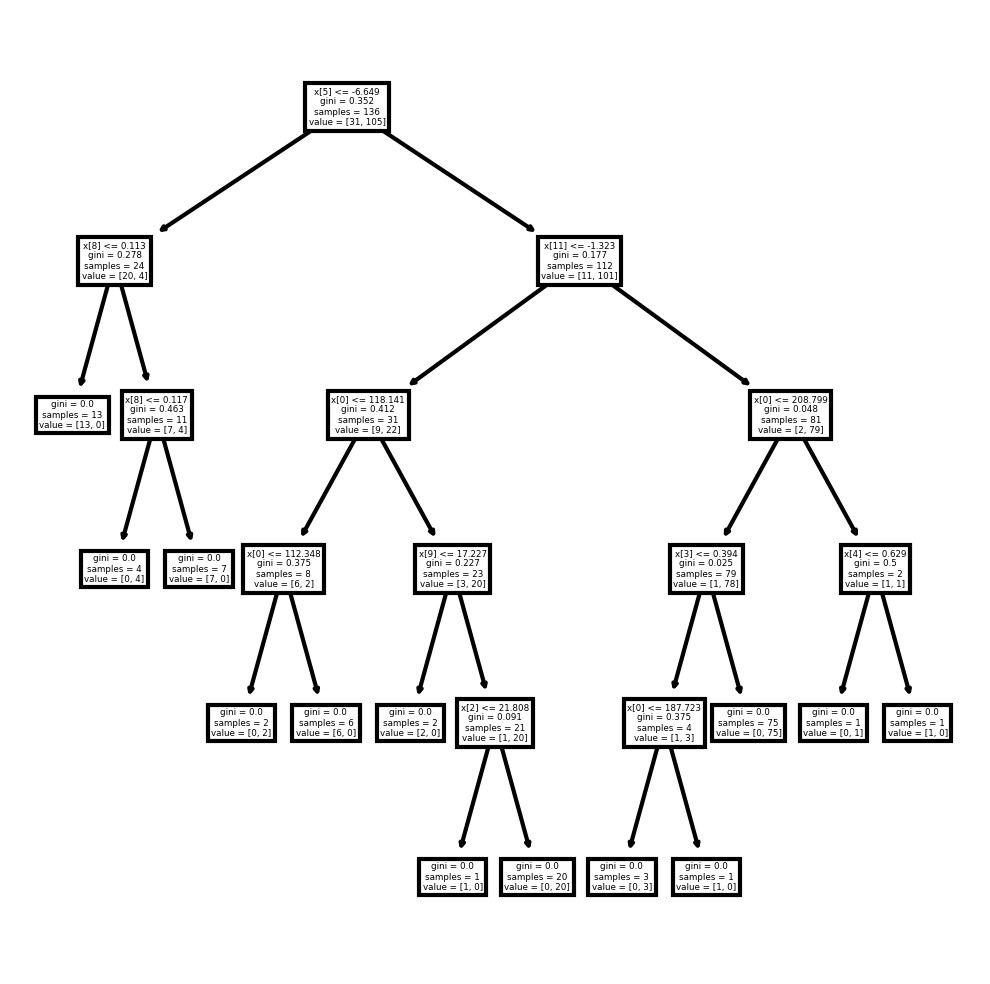

In [111]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf,filled = True);
fig.savefig('imagename.png')
tree.plot_tree(clf);    

### Random forest

In [120]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predRF = rfc.predict(X_test)

accuracy = accuracy_score(y_test,predRF)*100
print("Accuracy of Model is:",accuracy)

Accuracy of Model is: 91.52542372881356


# XG-Boost

In [122]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [139]:
predXGB =  xgb_classifier.predict(X_test)

print(predXGB)
print("\nAccuracy of Model::",accuracy_score(y_test,predXGB))

[0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0]

Accuracy of Model:: 0.864406779661017
